# REINFORCE in PyTorch

Just like we did before for Q-learning, this time we'll design a PyTorch network to learn `CartPole-v0` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from approximate Q-learning, so you'll find it more or less familiar and even simpler.

In [ ]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !pip install -q gym[classic_control]==0.18.0
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb.


In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

A caveat: with some versions of `pyglet`, the following cell may crash with `NameError: name 'base' is not defined`. The corresponding bug report is [here](https://github.com/pyglet/pyglet/issues/134). If you see this error, try restarting the kernel.

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:506: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  f"The environment {path} is out of date. You should consider "


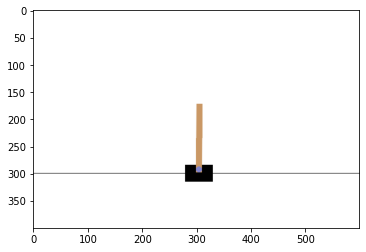

In [ ]:
env = gym.make("CartPole-v0")

# gym compatibility: unwrap TimeLimit
if hasattr(env, '_max_episode_steps'):
    env = env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

For numerical stability, please __do not include the softmax layer into your network architecture__.
We'll use softmax or log-softmax where appropriate.

In [ ]:
state_dim

(4,)

In [ ]:
import torch
import torch.nn as nn

In [ ]:
# Build a simple neural network that predicts policy logits. 
# Keep it simple: CartPole isn't worth deep architectures.
model = nn.Sequential(
  nn.Linear(state_dim[0], 50),
  nn.ReLU(),
  nn.Linear(50, 50),
  nn.ReLU(),
  nn.Linear(50, n_actions)
)

#### Predict function

Note: output value of this function is not a torch tensor, it's a numpy array.
So, here gradient calculation is not needed.
<br>
Use [no_grad](https://pytorch.org/docs/stable/autograd.html#torch.autograd.no_grad)
to suppress gradient calculation.
<br>
Also, `.detach()` (or legacy `.data` property) can be used instead, but there is a difference:
<br>
With `.detach()` computational graph is built but then disconnected from a particular tensor,
so `.detach()` should be used if that graph is needed for backprop via some other (not detached) tensor;
<br>
In contrast, no graph is built by any operation in `no_grad()` context, thus it's preferable here.

In [ ]:
def predict_probs(states):
    """ 
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :returns: numpy array of shape [batch, n_actions]
    """
    # convert states, compute logits, use softmax to get probability
    with torch.no_grad():
      y_pred = torch.softmax(model(torch.tensor(states, dtype=torch.float)), axis=1)
    return y_pred.numpy()

In [ ]:
test_states = np.array([env.reset() for _ in range(5)])
test_probas = predict_probs(test_states)
assert isinstance(test_probas, np.ndarray), \
    "you must return np array and not %s" % type(test_probas)
assert tuple(test_probas.shape) == (test_states.shape[0], env.action_space.n), \
    "wrong output shape: %s" % np.shape(test_probas)
assert np.allclose(np.sum(test_probas, axis=1), 1), "probabilities do not sum to 1"

### Play the game

We can now use our newly built agent to play the game.

In [ ]:
def generate_session(env, t_max=1000):
    """ 
    Play a full session with REINFORCE agent.
    Returns sequences of states, actions, and rewards.
    """
    # arrays to record session
    states, actions, rewards = [], [], []
    s = env.reset()

    for t in range(t_max):
        # action probabilities array aka pi(a|s)
        action_probs = predict_probs(np.array([s]))[0]

        # Sample action with given probabilities.
        a = np.random.choice(n_actions, p=action_probs)
        new_s, r, done, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    return states, actions, rewards

In [ ]:
# test it
states, actions, rewards = generate_session(env)

In [ ]:
actions

[1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]

### Computing cumulative rewards

$$
\begin{align*}
G_t &= r_t + \gamma r_{t + 1} + \gamma^2 r_{t + 2} + \ldots \\
&= \sum_{i = t}^T \gamma^{i - t} r_i \\
&= r_t + \gamma * G_{t + 1}
\end{align*}
$$

In [ ]:
def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    Take a list of immediate rewards r(s,a) for the whole session 
    and compute cumulative returns (a.k.a. G(s,a) in Sutton '16).
    
    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    A simple way to compute cumulative rewards is to iterate from the last
    to the first timestep and compute G_t = r_t + gamma*G_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    R = [0]
    for i in range(len(rewards)):
      R.append(rewards[-i-1] + gamma * R[-1])

    return R[::-1][:-1]

In [ ]:
get_cumulative_rewards(rewards)
assert len(get_cumulative_rewards(list(range(100)))) == 100
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
    [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
    [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0),
    [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum_{s_i,a_i} G(s_i,a_i) $$

REINFORCE defines a way to compute the gradient of the expected reward with respect to policy parameters. The formula is as follows:

$$ \nabla_\theta \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \nabla_\theta \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

We can abuse PyTorch's capabilities for automatic differentiation by defining our objective function as follows:

$$ \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

When you compute the gradient of that function with respect to network weights $\theta$, it will become exactly the policy gradient.

In [ ]:
def to_one_hot(y_tensor, ndims):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    y_one_hot = torch.zeros(
        y_tensor.size()[0], ndims).scatter_(1, y_tensor, 1)
    return y_one_hot

In [ ]:
# Your code: define optimizers
model = nn.Sequential(
  nn.Linear(state_dim[0], 50),
  nn.ReLU(),
  nn.Linear(50, 50),
  nn.ReLU(),
  nn.Linear(50, n_actions)
)

optimizer = torch.optim.Adam(model.parameters(), 5e-4)


def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """

    # cast everything into torch tensors
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int32)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)

    # predict logits, probas and log-probas using an agent.
    logits = model(states)
    probs = nn.functional.softmax(logits, -1)
    log_probs = nn.functional.log_softmax(logits, -1)

    assert all(isinstance(v, torch.Tensor) for v in [logits, probs, log_probs]), \
        "please use compute using torch tensors and don't use predict_probs function"

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    log_probs_for_actions = torch.sum(
        log_probs * to_one_hot(actions, env.action_space.n), dim=1)
   
    # Compute loss here. Don't forgen entropy regularization with `entropy_coef` 
    entropy = (probs*log_probs).sum(-1).mean() * entropy_coef
    loss = -torch.mean(log_probs_for_actions*cumulative_returns) + entropy

    # Gradient descent step
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # technical: return session rewards to print them later
    return np.sum(rewards)

### The actual training

In [ ]:
for i in range(100):
    rewards = [train_on_session(*generate_session(env)) for _ in range(100)]  # generate new sessions
    
    print("mean reward:%.3f" % (np.mean(rewards)))
    
    if np.mean(rewards) > 500:
        print("You Win!")  # but you can train even further
        break

mean reward:20.400
mean reward:22.830
mean reward:31.190
mean reward:44.090
mean reward:50.540
mean reward:55.710
mean reward:66.750
mean reward:79.810
mean reward:158.410
mean reward:139.260
mean reward:167.010
mean reward:310.920
mean reward:272.440
mean reward:119.480
mean reward:246.590
mean reward:292.280
mean reward:134.220
mean reward:169.470
mean reward:160.180
mean reward:131.860
mean reward:513.010
You Win!


### Results & video

In [ ]:
pip install ffmpeg

In [ ]:
# Record sessions
import gym.wrappers

with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True) as env_monitor:
    sessions = [generate_session(env_monitor) for _ in range(100)]

In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1] # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

In [ ]:
!pip install gym-video-streamer

In [ ]:
!pip install --upgrade gym-video-streamer

In [ ]:
import gym
from gym_video_streamer import SetupVirtualDisplay
from gym_video_streamer import VideoStreamer  # Streaming Wrapper

In [ ]:
SetupVirtualDisplay()

In [ ]:
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""


def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env


In [ ]:
env = wrap_env(gym.make("CartPole-v1"))

observation = env.reset()

while True:

    env.render()

    # your agent goes here
    action = env.action_space.sample()

    observation, reward, done, info = env.step(action)

    if done:
        break

env.close()
show_video()

Setup rendering dependencies for Google Colaboratory.

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

Install d3rlpy!

In [ ]:
!pip install d3rlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Setup cartpole dataset.

In [ ]:
pip install pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from d3rlpy.datasets import get_cartpole

# get CartPole dataset
dataset, env = get_cartpole()

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:506: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  f"The environment {path} is out of date. You should consider "


Setup data-driven deep reinforcement learning algorithm.

In [ ]:
from d3rlpy.algos import DiscreteCQL
from d3rlpy.metrics.scorer import discounted_sum_of_advantage_scorer
from d3rlpy.metrics.scorer import evaluate_on_environment
from d3rlpy.metrics.scorer import td_error_scorer
from d3rlpy.metrics.scorer import average_value_estimation_scorer
from sklearn.model_selection import train_test_split

# setup CQL algorithm
cql = DiscreteCQL(use_gpu=False)

# split train and test episodes
train_episodes, test_episodes = train_test_split(dataset, test_size=0.2)

# start training
cql.fit(train_episodes,
        eval_episodes=test_episodes,
        n_epochs=1,
        scorers={
            'environment': evaluate_on_environment(env), # evaluate with CartPol-v0 environment
            'advantage': discounted_sum_of_advantage_scorer, # smaller is better
            'td_error': td_error_scorer, # smaller is better
            'value_scale': average_value_estimation_scorer # smaller is better
        })

2022-10-05 19:26.19 [debug    ] RoundIterator is selected.
2022-10-05 19:26.19 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221005192619
2022-10-05 19:26.19 [debug    ] Building models...
2022-10-05 19:26.19 [debug    ] Models have been built.
2022-10-05 19:26.19 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221005192619/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'DiscreteCQL', 'observation

Epoch 1/1:   0%|          | 0/2446 [00:00<?, ?it/s]

2022-10-05 19:26.51 [info     ] DiscreteCQL_20221005192619: epoch=1 step=2446 epoch=1 metrics={'time_sample_batch': 0.00040431511957725346, 'time_algorithm_update': 0.009919222416881646, 'loss': 0.6871148673170234, 'time_step': 0.010637442985715577, 'environment': 200.0, 'advantage': -2.4476615412555507, 'td_error': 1.1223799951982014, 'value_scale': 1.1077292382144386} step=2446
2022-10-05 19:26.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221005192619/model_2446.pt


[(1,
  {'time_sample_batch': 0.00040431511957725346,
   'time_algorithm_update': 0.009919222416881646,
   'loss': 0.6871148673170234,
   'time_step': 0.010637442985715577,
   'environment': 200.0,
   'advantage': -2.4476615412555507,
   'td_error': 1.1223799951982014,
   'value_scale': 1.1077292382144386})]

Setup rendering utilities for Google Colaboratory.

In [ ]:
pip install gym==0.22

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import glob
import io
import base64

from gym.wrappers import Monitor
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

# start virtual display
display = Display(visible=0, size=(1400, 900))
display.start()

# play recorded video
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''
            <video alt="test" autoplay loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

Record video!

In [ ]:
# wrap Monitor wrapper
env = Monitor(env, './video', force=True)

class cartpole():
  def __init__(self, model):
    self.model = model
  
  def predict(self, X):
    #print([np.argmax(torch.softmax(self.model(torch.tensor(X)), axis=1).detach().numpy())])
    return [np.argmax(torch.softmax(self.model(torch.tensor(X)), axis=1).detach().numpy())]

# evaluate
evaluate_on_environment(env)(cartpole(model))

200.0

Let's see how it works!

In [ ]:
show_video()